In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D


#### **Equilíbrio Parcial - Bets** 

In [ ]:
def bets_sensitivity(pct_viciados, I_a, delta, gamma, p_y, beta, alpha, P):
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    import numpy as np

    # --------- Parâmetros populacionais ----------
    #P = 24_000_000 # Estimativa Banco Central
    n = int(P * pct_viciados) #Definir na função qual o % de pessoas viciadas em apostas. Dentro do subgrupo de apostadores ativos

    # --------- Preço fixo de y ----------
    #p_y = 4000 - preço da cesta alternativa às bets normalizado. Na Stone-Geary considerei o theta igual a 1, i.e. uma cesta no mínimo, que custa R$ 4.000. Seria uma medida de "custo de vida"
    p_x_values = np.linspace(1, 15, 100) # Valores possíveis de px para plotar o gráfico abaixo
    theta = 1

    # --------- Função formatadora para eixo y em bilhões ou milhões ----------
    def formatar_em_bilhoes(x, _):
        return f'{x / 1e9:,.1f}B'.replace(',', '.')
    
    def formatar_em_milhoes(x, _):
        return f'{x / 1e6:,.1f}M'.replace(',', '.')

    # --------- Função de demanda agregada ----------
    def demanda_agregada(p_x, I_a, delta, gamma, p_y, beta, alpha, n, P):
        x_viciados = gamma + (beta / p_x) * (I_a - gamma * p_x)
        x_normais = (alpha / p_x) * (delta + I_a - theta * p_y) # delta é um parâmetro para expressar "desigualdade" entre os consumidores. Assumi que os "normais" tem renda maior que os "adictos"
        return n * x_viciados + (P - n) * x_normais

    # --------- Curva de referência com valores fixos ----------
    baseline = {
        'P': 24_000_000, #Estimativa BCB
        'pct_viciados': 0.02, # WHO sugere que 1,2% da população adulta tem um problema com apostas. Estamos estimando que 2% é viciado, isto é, tem função de utilidade com viés para bets
        'I_a': 1500, # salário mínimo + bolsa família. Dado o "erro" cognitivo, estamos assumindo que este extrato da população tem renda menor
        'delta': 5500, # ou seja, renda média dos "normais" em R$ 7.000. Consumidor que faz 7.000. É um apostador com renda média maior. 
        'gamma': 10, # mínimo de tickets (Stone-Gery) que o adicto faz por mês. 1 por dia.
        'p_y': 4000, # quantas cestas no mínimo, o normal gasta dos demais itens por mês. Vou colocar uma cesta e normalizar no preço o que seria uma cesta normal, i.e. 2000
        'beta': 0.25, # % da renda que o adicto gasta com bets
        'alpha': 0.02 # % da renda que o normal gasta com bets, conforme a renda aumenta a % alocada em bets se aproxima disso
    }
    n_base = int(P * baseline['pct_viciados'])
    # Curva baseline para referencial
    X_baseline = demanda_agregada( p_x_values,
                                   P = baseline['P'],
                                   I_a=baseline['I_a'],
                                   delta=baseline['delta'],
                                   gamma=baseline['gamma'],
                                   p_y=baseline['p_y'],
                                   beta=baseline['beta'],
                                   alpha=baseline['alpha'],
                                   n=baseline['P']*baseline['pct_viciados'])

    # --------- Curva ajustável com sliders ----------
    X_ajustada = demanda_agregada(p_x_values, I_a, delta, gamma, p_y, beta, alpha, n,P)

    # --------- Plot ---------
    plt.figure(figsize=(10, 6))
    plt.plot(X_baseline, p_x_values, label="Demanda (Cenário Base)", color='blue')
    plt.plot(X_ajustada, p_x_values, '-', label="Demanda (Shift)", color='black')

    #Curva de oferta de longo-prazo
    #plt.axhline(y=4, color='red', linestyle='-', linewidth=1,
                #label='Oferta de Longo Prazo ($p_x = 4$)')

    #plt.title("Curva de Demanda - Bets", fontweight='bold')
    plt.xlabel("Demanda $X_{bets}$ (em milhões de apostas por mês)")
    plt.ylabel("Preço implícito de apostar (EV negativo) ($p_x$)")
    plt.grid(True)
    plt.xlim(0, 1_000_000_000)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(formatar_em_milhoes))
    plt.legend()
    plt.tight_layout()
    plt.show()

baseline = {
    'P': 24_000_000,
    'pct_viciados': 0.02,
    'I_a': 1500,
    'delta': 5500,
    'gamma': 10,
    'p_y': 4000,
    'beta': 0.25,
    'alpha': 0.02
}

bets_controls = widgets.interactive(
    bets_sensitivity,
    P=widgets.IntSlider(value=baseline['P'], min=10_000_000, max=60_000_000, step=1_000_000),
    pct_viciados=widgets.FloatSlider(value=baseline['pct_viciados'],  min=0.00, max=0.10, step=0.005),
    I_a         =widgets.IntSlider(  value=baseline['I_a'],           min=1100, max=2500, step=100),
    delta       =widgets.IntSlider(  value=baseline['delta'],         min=0,    max=10000,step=250),
    gamma       =widgets.IntSlider(  value=baseline['gamma'],         min=5,    max=50,   step=1),
    p_y         =widgets.IntSlider(value=baseline['p_y'],             min=3000,  max=6000,  step=100),
    beta        =widgets.FloatSlider(value=baseline['beta'],          min=0.10, max=0.50, step=0.05),
    alpha       =widgets.FloatSlider(value=baseline['alpha'],         min=0.01, max=0.10, step=0.005)
)

display(bets_controls)


interactive(children=(FloatSlider(value=0.02, description='pct_viciados', max=0.1, step=0.005), IntSlider(valu…

#### **Curva de Demanda - Cesta bem alternativo** 

In [29]:

# ----------- Função de demanda agregada por y ---------------
def demanda_y_total(p_y, p_x, I_a, delta, gamma, theta, beta, alpha, P, pct_viciados):
    
    n = int(P * pct_viciados)

    y_viciados = ((1 - beta) / p_y) * (I_a - gamma * p_x)
    y_normais = theta + ((1 - alpha) / p_y) * (delta + I_a - theta * p_y)

    Y_total = n * y_viciados + (P - n) * y_normais
    return Y_total

# ----------- Função principal com sliders interativos ------------
def y_sensitivity(P, p_x, pct_viciados, I_a, delta, gamma, beta, alpha):
    #P = 24_000_000 
    theta = 1
    p_y_values = np.linspace(3000, 8000, 100)

    # curva atual (com sliders)
    Y_shift = [demanda_y_total(p_y, p_x, I_a, delta, gamma, theta, beta, alpha, P, pct_viciados)
               for p_y in p_y_values]

    # baseline fixo
    base = {
        'P': 24_000_000,
        'p_x': 4,
        'pct_viciados': 0.02,
        'I_a': 1500,
        'delta': 5500,
        'gamma': 10,
        'beta': 0.25,
        'alpha': 0.02
    }

    Y_baseline = [demanda_y_total( p_y, base['p_x'], base['I_a'], base['delta'], base['gamma'],
                                  theta, base['beta'], base['alpha'], base['P'], base['pct_viciados']
                                  ) for p_y in p_y_values]

    # ----------- Plot ------------
    plt.figure(figsize=(10, 6))
    plt.plot(p_y_values, Y_baseline, label='Demanda (Baseline)', color='blue')
    plt.plot(p_y_values, Y_shift, label='Demanda (Shift)', color='black')

    #plt.title("Curva de Demanda por $y$ (Cesta Cotidiana)", fontweight='bold')
    plt.xlabel("Preço da Cesta ($p_y$)")
    plt.ylabel("Demanda $Y_{bets}$ (em milhões de cestas/mês)")
    plt.grid(True)
    plt.ylim(20_000_000, 60_000_000)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:,.0f}M'.replace(',', '.')))
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------- Sliders interativos ------------
baseline = {
    'P': 24_000_000,
    'p_x': 4,
    'pct_viciados': 0.02,
    'I_a': 1500,
    'delta': 5500,
    'gamma': 10,
    'beta': 0.25,
    'alpha': 0.02
}

y_controls = widgets.interactive(
    y_sensitivity,
    P=widgets.IntSlider(value=baseline['P'], min=10_000_000, max=60_000_000, step=1_000_000),
    p_x=widgets.FloatSlider(value=baseline['p_x'], min=0.0, max=15.0, step=0.5),
    pct_viciados=widgets.FloatSlider(value=baseline['pct_viciados'], min=0.00, max=0.10, step=0.005),
    I_a=widgets.IntSlider(value=baseline['I_a'], min=1100, max=2500, step=100),
    delta=widgets.IntSlider(value=baseline['delta'], min=0, max=10000, step=250),
    gamma=widgets.IntSlider(value=baseline['gamma'], min=5, max=50, step=1),
    beta=widgets.FloatSlider(value=baseline['beta'], min=0.10, max=0.50, step=0.05),
    alpha=widgets.FloatSlider(value=baseline['alpha'], min=0.01, max=0.10, step=0.005)
)

display(y_controls)


interactive(children=(IntSlider(value=24000000, description='P', max=60000000, min=10000000, step=1000000), Fl…

#### **Função de Utilidade Stone-Geary** 

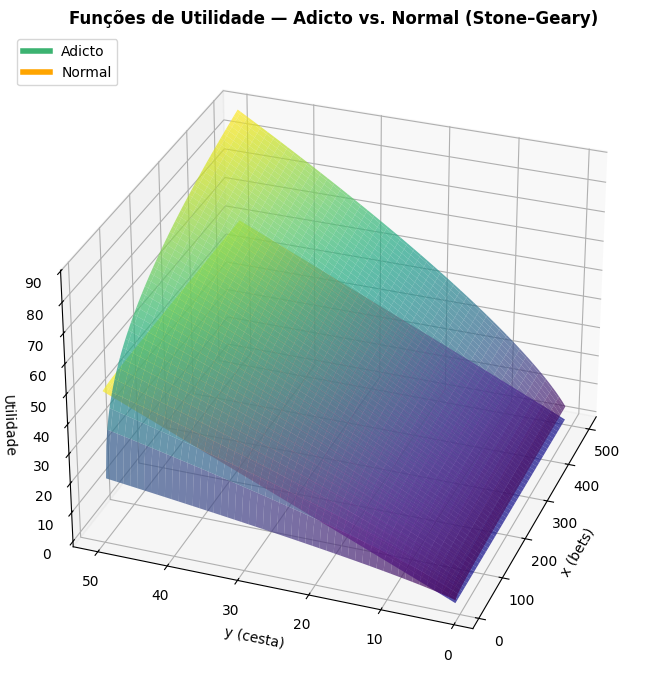

In [13]:


# ----- Grid para os valores de x e y -----
x_vals = np.linspace(11, 500, 100)     # x ≥ 300 (mínimo para adicto)
y_vals = np.linspace(1, 50, 100)    # y ≥ 2000 (mínimo para normal)
X, Y = np.meshgrid(x_vals, y_vals)

# ----- Função de utilidade do consumidor adicto -----
U_adicto = (X - 10) ** 0.25 * Y ** 0.75

# ----- Função de utilidade do consumidor normal -----
U_normal = X ** 0.01 * (Y - 1) ** 0.99

# ----- Plot único com ambas as superfícies -----
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=200)  # <- gira horizontalmente em 180º


# Superfície do consumidor adicto (verde-azulado)
surf1 = ax.plot_surface(X, Y, U_adicto, cmap='viridis', alpha=0.7, edgecolor='none', label='Adicto')

# Superfície do consumidor normal (magenta-amarelado)
surf2 = ax.plot_surface(X, Y, U_normal, cmap='plasma', alpha=0.7, edgecolor='none', label='Normal')

# Rótulos e título
ax.set_title("Funções de Utilidade — Adicto vs. Normal (Stone–Geary)",fontweight='bold')
ax.set_xlabel("x (bets)")
ax.set_ylabel("y (cesta)")
ax.set_zlabel("Utilidade")

# Legenda manual (porque plot_surface não lida com label diretamente)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='mediumseagreen', lw=4, label='Adicto'),
    Line2D([0], [0], color='orange', lw=4, label='Normal')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\Gilberto Barbosa\AppData\Local\Temp\ipykernel_37000\2439812584.py:12: RuntimeWarning: invalid value encountered in power
  U_adicto = np.where(X > 10, (X - 10) ** 0.25 * Y ** 0.75, np.nan)
C:\Users\Gilberto Barbosa\AppData\Local\Temp\ipykernel_37000\2439812584.py:15: RuntimeWarning: invalid value encountered in power
  U_normal = np.where(Y > 1, X ** 0.02 * (Y - 1) ** 0.98, np.nan)


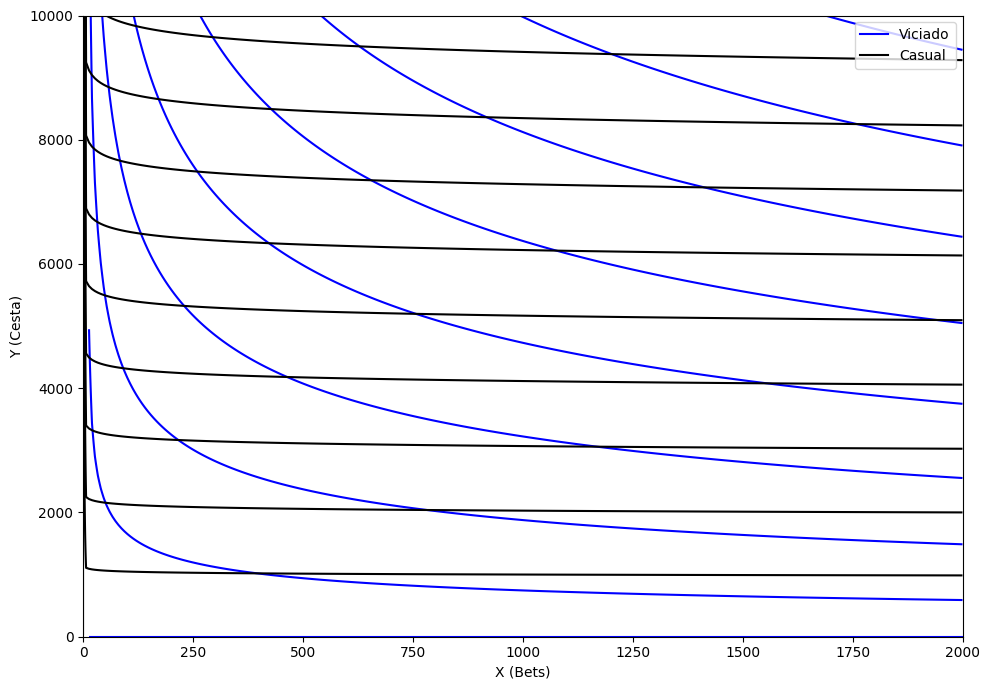

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Grid de x e y maiores que zero -----
x_vals = np.linspace(0, 2000, 300)     # Agora inclui x < 300 para ver o "vazio"
y_vals = np.linspace(0, 10000, 300)    # Inclui y < 2000 para ver corte
X, Y = np.meshgrid(x_vals, y_vals)

# ----- Funções de utilidade com domínio restrito -----

# Utilidade do adicto só definida para x > 300
U_adicto = np.where(X > 10, (X - 10) ** 0.25 * Y ** 0.75, np.nan)

# Utilidade do normal só definida para y > 2000
U_normal = np.where(Y > 1, X ** 0.02 * (Y - 1) ** 0.98, np.nan)

# ----- Plot das curvas de indiferença -----
plt.figure(figsize=(10, 7))

# Curvas do adicto (linhas sólidas azuis)
contour_adicto = plt.contour(X, Y, U_adicto, levels=10, colors='blue', linestyles='solid')

# Curvas do normal (linhas tracejadas pretas)
contour_normal = plt.contour(X, Y, U_normal, levels=10, colors='black', linestyles='solid')

# Legenda manual
from matplotlib.lines import Line2D

legend_lines = [
    Line2D([0], [0], color='blue', linestyle='solid', label='Viciado'),
    Line2D([0], [0], color='black', linestyle='solid', label='Casual'),
]

plt.legend(handles=legend_lines, loc='upper right')

# Limites do gráfico: R+²
plt.xlim(0, 2000)
plt.ylim(0, 10000)

# Rótulos e legenda
plt.xlabel("X (Bets)")
plt.ylabel("Y (Cesta)")
plt.grid(False)

plt.tight_layout()
plt.show()
